# Simulation Mise à jour

Ce notebook renferme la simulation permettatn de déterminer la fréqunce de mise à jour du modèle de clustering concernant le projet "Segmentez des clients d'un site e-commerce".

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px
import time
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
from sklearn import cluster, preprocessing
from sklearn.metrics import adjusted_rand_score

### Méthodes du projet

In [2]:
def create_data_for_model(df):
    """ Elabore le dataset d'étude pour l'utilisation de nos modèles """
    last_purchase_date = df["order_purchase_timestamp"].max() + timedelta(days=1)
    aggregation = {
        'order_purchase_timestamp': lambda x: (last_purchase_date - x.max()).days,
        'order_id': 'count',
        'order_value_by_item': ['sum']
    }
    temp_data = df.groupby(['customer_unique_id']).agg(aggregation)
    temp_data.columns = pd.Index([e[0] + "_" + e[1] for e in temp_data.columns.tolist()])
    temp_data.rename(
        columns={'order_purchase_timestamp_<lambda>': 'rfm_recency',
                 'order_id_count': 'rfm_frequency',
                 'order_value_by_item_sum': 'rfm_monetary'}, inplace=True)
    return temp_data

In [3]:
def display_bilan_clusters_all(df, silent=False):
    """ Affiche le tableau comparatif des variables par cluster """
    agg = {}
    for col in df.columns:
        agg[col] = 'mean'
    agg['cluster'] = 'count'
    # on regroupe par customer_unique_id pour appliquer les aggrégations
    clustering_table = df.groupby(["cluster"]).agg(agg)
    # on renomme les colonnes pour l'étude des modèles
    clustering_table.rename(columns={'cluster': 'cluster_size'}, inplace=True)
    clustering_table["cluster_perc"] = round(clustering_table["cluster_size"] / len(df) * 100, 1)
    clustering_table.drop(-1, axis=0, inplace=True, errors='ignore') # pour supprimer la ligne de cluster de bruit du DBSCAN
    if not silent:
        display(clustering_table.head())
    return clustering_table

In [4]:
def compute_clustering_by_period(periodic_data, nb_week=1, silent=False):
    """ Identifie les clusters et calcule les données pertinentes pour chaque période de temps """
    result = []
    result_mean = []
    min_period = periodic_data["week_period"].min()
    max_period = periodic_data["week_period"].max()
    list_weekly_period = periodic_data["week_period"].unique()
    for idx, period in enumerate(list_weekly_period[::nb_week]):
        year, week = period.split("-")

        week = int(week)-nb_week
        if week <= 0:
            week += 52
            year = str(int(year)-1)
        week = str(week).zfill(2)
        week_ago = year + "-" + week

        debut = max(min_period, week_ago)
        fin = period
        if not silent:
            print("Période de", debut, "à", fin)

        data_period = periodic_data.loc[(periodic_data["week_period"] > debut) & (periodic_data["week_period"] <= fin), :]
        if len(data_period) < 3:
            for clust in [0, 1, 2]:
                result.append({
                    'week_period': period,
                    'cluster': clust,
                    'monetary': 0,
                    'cluster_size': 0
                })
            result_mean.append({
                'week_period': period,
                'monetary': 0,
                'cluster_size': 0
            })
            continue
        data_period_model = create_data_for_model(data_period)

        X = data_period_model.values
        scaler = preprocessing.RobustScaler()
        X_norm = scaler.fit_transform(X)

        kmeans = cluster.KMeans(n_clusters=3, random_state=42)
        kmeans.fit(X_norm)

        cluster_map = pd.DataFrame()
        cluster_map['customer_unique_id'] = data_period_model.index.values
        cluster_map['cluster'] = kmeans.labels_
        data_w_cluster = pd.merge(data_period_model, cluster_map, on="customer_unique_id", how="inner")
        data_w_cluster.set_index("customer_unique_id", inplace=True)
        res = display_bilan_clusters_all(data_w_cluster, silent=silent)

        # on tri par taille de cluster du plus petit au plus grand
        res = res.sort_values(by="cluster_size").reset_index(drop=True)
        for index, row in res.iterrows():
            result.append({
                'week_period': period,
                'cluster': index,
                'monetary': row["rfm_monetary"],
                'cluster_size': row["cluster_size"]
            })
        result_mean.append({
            'week_period': period,
            'monetary': res["rfm_monetary"].mean(),
            'cluster_size': res["cluster_size"].sum()
        })
    return result, result_mean

In [5]:
def compute_period(df):
    """ Identifie les périodes en semaine et en mois dans un df """
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    df["period"] = df['order_purchase_timestamp'].dt.strftime('%Y-%m')
    df["week_period"] = df['order_purchase_timestamp'].dt.strftime('%Y-%V')
    df = df.sort_values(by="week_period")
    return df

## Chargement des données

In [6]:
data = pd.read_csv("simu_dataset.csv", encoding='utf-8', sep='\t', index_col=0)

In [7]:
data.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,efficient_delivery_elapse,review_score,order_item_id,product_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,order_value_by_item
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-25 10:35:35,2017-06-05,10.558623,4,1,a9516a079e37a9c9c36b9b78b10169e8,22.4982,3.9384,office_furniture,41.0,1141.0,1.0,26.4366
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-28 00:09:50,2017-12-19,20.993171,1,2,a9516a079e37a9c9c36b9b78b10169e8,20.3382,4.4820,office_furniture,41.0,1141.0,1.0,49.6404
2,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-26 09:54:04,2017-06-12,16.587454,3,1,a9516a079e37a9c9c36b9b78b10169e8,22.4982,2.8116,office_furniture,41.0,1141.0,1.0,25.3098
3,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-28 21:09:00,2018-03-22,21.118750,4,1,a9516a079e37a9c9c36b9b78b10169e8,19.2582,5.5062,office_furniture,41.0,1141.0,1.0,24.7644
4,fd3a0b1bd209f0e7d420c9c3d1127613,567ab47ca4deb92d46dbf54dce07d0a7,574fe1739f65af76badd0999db300b4f,delivered,2017-03-23 15:10:17,2017-04-11 10:16:56,2017-04-24,12.571574,4,1,a9516a079e37a9c9c36b9b78b10169e8,22.8582,2.7108,office_furniture,41.0,1141.0,1.0,25.5690


## Filtre par période

On identifie chaque ligne selon la période de l'année.

In [8]:
periodic_data = compute_period(data)

In [9]:
periodic_data.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,efficient_delivery_elapse,review_score,order_item_id,product_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,order_value_by_item,period,week_period
20475,08c5351a6aca1c1589a38f244edeee9d,b7d76e111c89f7ebf14761390f0f7d17,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-09-04 21:15:19,2016-10-20 00:00:00,2016-10-20,0.000000,1,1,c1488892604e4ba5cff5b4eb4d595400,7.1982,5.7006,furniture_decor,59.0,426.0,2.0,12.8988,2016-09,2016-35
99097,08c5351a6aca1c1589a38f244edeee9d,b7d76e111c89f7ebf14761390f0f7d17,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-09-04 21:15:19,2016-10-20 00:00:00,2016-10-20,0.000000,1,2,f293394c72c9b5fafd7023301fc21fc2,5.9220,5.7006,furniture_decor,41.0,754.0,3.0,23.2452,2016-09,2016-35
95413,683c54fc24d40ee9f8a6fc179fd9856c,4854e9b3feff728c13ee5fc7d1547e92,e5fa5a7210941f7d56d0208e4e071d35,canceled,2016-09-05 00:15:34,2016-10-28 00:00:00,2016-10-28,0.000000,1,1,f3c2d01a84c947b078e32bbef0718962,10.7100,2.8008,telephony,42.0,381.0,1.0,13.5108,2016-09,2016-36
70360,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,-36.324745,1,3,5a6b04657a4c5ee34285d1e4619a96b4,8.0982,0.5094,health_beauty,34.0,1036.0,1.0,25.8228,2016-09,2016-37
100376,b106b360fe2ef8849fbbd056f777b4d5,0eb1ee9dba87f5b36b4613a65074337c,71303d7e93b399f5bcd537d124c0bcfa,canceled,2016-10-02 22:07:52,2016-10-25 00:00:00,2016-10-25,0.000000,1,1,d2998d7ced12f83f9b832f33cf6507b6,18.0000,1.6812,baby,32.0,561.0,1.0,19.6812,2016-10,2016-39


## Weekly

In [10]:
print("Les périodes vont de", periodic_data["week_period"].min(), "à", periodic_data["week_period"].max())

Les périodes vont de 2016-35 à 2018-36


Regardons d'abord l'évolution du comportement des clients par semaine.

In [11]:
result, result_mean = compute_clustering_by_period(periodic_data, nb_week=1)

Période de 2016-35 à 2016-35
Période de 2016-35 à 2016-36
Période de 2016-36 à 2016-37
Période de 2016-38 à 2016-39
Période de 2016-39 à 2016-40


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,3.577778,1.288889,82.259320,45,17.0
1,4.009524,1.023810,20.303906,210,79.5
2,4.111111,1.333333,190.915800,9,3.4


Période de 2016-40 à 2016-41


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,1.0,1.0,15.254129,31,88.6
1,1.0,1.0,141.264000,1,2.9
2,1.0,2.0,59.893800,3,8.6


Période de 2016-50 à 2016-51
Période de 2016-52 à 2017-01


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,2.958333,1.125,13.219425,24,77.4
1,2.000000,1.000,114.159600,3,9.7
2,4.000000,4.000,12.956400,4,12.9


Période de 2017-01 à 2017-02


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,3.65000,1.150000,85.602600,20,26.7
1,3.37037,1.018519,17.795467,54,72.0
2,1.00000,6.000000,106.716600,1,1.3


Période de 2017-02 à 2017-03


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,5.268817,1.043011,18.646665,93,50.3
1,4.285714,1.285714,103.032686,21,11.4
2,1.943662,1.056338,18.450254,71,38.4


Période de 2017-03 à 2017-04


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.076923,1.024476,20.264570,286,82.7
1,4.358491,1.150943,84.071174,53,15.3
2,3.571429,2.714286,301.034057,7,2.0


Période de 2017-04 à 2017-05


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,3.820388,1.048544,24.346529,412,93.8
1,3.791667,1.166667,132.923625,24,5.5
2,5.000000,1.000000,556.604400,3,0.7


Période de 2017-05 à 2017-06


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.342324,1.024896,21.008215,482,92.3
1,2.000000,1.000000,959.897700,2,0.4
2,4.210526,1.421053,119.464058,38,7.3


Période de 2017-06 à 2017-07


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.349845,1.021672,18.200842,323,82.8
1,5.333333,1.400000,167.427840,15,3.8
2,4.576923,1.346154,71.374569,52,13.3


Période de 2017-07 à 2017-08


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.072046,1.025937,20.251852,347,94.8
1,6.000000,1.000000,648.444600,1,0.3
2,4.666667,1.444444,141.364600,18,4.9


Période de 2017-08 à 2017-09


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,3.666667,1.277778,83.747267,54,11.5
1,3.782178,1.032178,18.483255,404,86.1
2,4.181818,1.000000,290.590364,11,2.3


Période de 2017-09 à 2017-10


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.236473,1.042084,19.494675,499,89.3
1,4.250000,1.500000,275.001300,8,1.4
2,4.057692,1.153846,92.400369,52,9.3


Période de 2017-10 à 2017-11


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.525424,1.372881,112.635031,59,9.8
1,4.394834,1.014760,21.755534,542,89.7
2,3.666667,1.000000,526.901400,3,0.5


Période de 2017-11 à 2017-12


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.322581,1.028674,19.131642,558,89.3
1,4.419355,1.209677,89.042023,62,9.9
2,4.400000,2.000000,374.846040,5,0.8


Période de 2017-12 à 2017-13


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.376838,1.047794,26.174617,544,98.7
1,2.000000,2.000000,1362.893400,1,0.2
2,3.000000,1.000000,376.861500,6,1.1


Période de 2017-13 à 2017-14


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.280000,1.160000,174.549024,25,4.4
1,4.106343,1.052239,23.615550,536,94.7
2,4.800000,1.000000,469.629000,5,0.9


Période de 2017-14 à 2017-15


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.489297,1.012232,14.863464,327,74.8
1,4.000000,1.157895,154.369800,19,4.3
2,4.153846,1.087912,53.395695,91,20.8


Période de 2017-15 à 2017-16


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,3.862000,1.052000,22.152359,500,90.7
1,6.000000,1.000000,806.319000,2,0.4
2,4.122449,1.081633,111.365853,49,8.9


Période de 2017-16 à 2017-17


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.364747,1.015707,19.332983,573,86.0
1,4.000000,1.250000,254.223450,8,1.2
2,4.329412,1.141176,77.378294,85,12.8


Période de 2017-17 à 2017-18


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.103448,1.037767,16.904619,609,80.3
1,3.000000,1.000000,232.743000,15,2.0
2,4.007463,1.186567,58.259888,134,17.7


Période de 2017-18 à 2017-19


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.162659,1.036775,21.403831,707,92.2
1,4.169811,1.339623,112.123630,53,6.9
2,5.142857,1.285714,407.666314,7,0.9


Période de 2017-19 à 2017-20


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.225282,1.038798,19.144399,799,88.5
1,4.266667,1.333333,235.334880,15,1.7
2,3.966292,1.426966,82.766649,89,9.9


Période de 2017-20 à 2017-21


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.374827,1.048409,24.520459,723,95.1
1,5.000000,1.000000,1210.798800,1,0.1
2,4.583333,1.500000,170.526650,36,4.7


Période de 2017-21 à 2017-22


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.252149,1.028653,18.429377,698,85.9
1,4.210526,1.157895,241.443758,19,2.3
2,4.239583,1.093750,72.182587,96,11.8


Période de 2017-22 à 2017-23


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.251647,1.052701,21.234671,759,93.7
1,5.500000,1.750000,482.816700,4,0.5
2,4.340426,1.446809,123.351472,47,5.8


Période de 2017-23 à 2017-24


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.334298,1.063676,21.421959,691,94.4
1,2.666667,1.111111,395.288600,9,1.2
2,4.687500,1.687500,132.323400,32,4.4


Période de 2017-24 à 2017-25


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.174603,1.042857,24.622223,630,98.0
1,3.166667,1.000000,266.204400,12,1.9
2,6.000000,6.000000,895.662000,1,0.2


Période de 2017-25 à 2017-26


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.057143,1.011111,18.826960,630,89.0
1,4.000000,1.313433,85.281555,67,9.5
2,4.727273,1.363636,237.054927,11,1.6


Période de 2017-26 à 2017-27


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.512195,1.292683,90.997529,82,10.3
1,4.666667,1.000000,385.178400,3,0.4
2,4.166900,1.025245,19.836651,713,89.3


Période de 2017-27 à 2017-28


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.164286,1.015714,15.895633,700,75.5
1,3.870968,1.677419,148.965619,31,3.3
2,4.525510,1.107143,47.834972,196,21.1


Période de 2017-28 à 2017-29


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.406739,1.036101,20.071044,831,89.6
1,4.584270,1.494382,89.747778,89,9.6
2,4.857143,1.571429,335.971029,7,0.8


Période de 2017-29 à 2017-30


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.227494,1.041363,19.968795,822,91.3
1,4.000000,1.421053,101.810179,76,8.4
2,4.500000,2.500000,440.169300,2,0.2


Période de 2017-30 à 2017-31


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.151515,1.206061,54.909349,165,17.2
1,4.235677,1.022135,16.599288,768,80.2
2,4.320000,1.160000,177.173568,25,2.6


Période de 2017-31 à 2017-32


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.286064,1.035452,21.330176,818,90.0
1,3.600000,1.600000,360.988920,5,0.6
2,4.465116,1.209302,98.041374,86,9.5


Période de 2017-32 à 2017-33


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.262931,1.042026,19.254728,928,92.2
1,4.140845,1.281690,101.466482,71,7.1
2,4.375000,1.875000,320.970600,8,0.8


Période de 2017-33 à 2017-34


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.199700,1.024024,15.937822,666,77.4
1,4.500000,1.304878,50.915162,164,19.0
2,4.612903,1.580645,138.593148,31,3.6


Période de 2017-34 à 2017-35


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.167082,1.027431,19.206195,802,81.6
1,4.200000,1.166667,230.936190,60,6.1
2,3.991736,1.231405,73.258944,121,12.3


Période de 2017-35 à 2017-36


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,3.777778,1.273504,74.252985,117,13.4
1,4.164138,1.022069,18.545018,725,83.3
2,5.357143,1.214286,222.242400,28,3.2


Période de 2017-36 à 2017-37


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.344792,1.027083,18.751622,960,85.1
1,4.147651,1.167785,74.106387,149,13.2
2,4.210526,1.421053,266.838821,19,1.7


Période de 2017-37 à 2017-38


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.326746,1.025033,17.691092,759,79.1
1,5.147059,1.235294,150.614735,34,3.5
2,4.449102,1.185629,56.168763,167,17.4


Période de 2017-38 à 2017-39


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.190211,1.041157,23.464774,899,95.8
1,3.000000,1.000000,2459.534400,1,0.1
2,4.000000,1.236842,188.268916,38,4.1


Période de 2017-39 à 2017-40


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.270878,1.047109,23.908061,934,95.9
1,4.432432,1.135135,190.155162,37,3.8
2,5.000000,1.666667,657.452400,3,0.3


Période de 2017-40 à 2017-41


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.284946,1.039785,21.216981,930,90.0
1,4.272727,1.181818,306.940745,11,1.1
2,4.510870,1.206522,105.492620,92,8.9


Période de 2017-41 à 2017-42


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.725000,1.337500,134.709660,80,7.2
1,4.269531,1.051758,23.584122,1024,92.7
2,6.000000,13.000000,1237.212000,1,0.1


Période de 2017-42 à 2017-43


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.305998,1.035496,19.133736,817,86.6
1,3.687500,1.187500,287.739337,16,1.7
2,4.236364,1.336364,86.015373,110,11.7


Période de 2017-43 à 2017-44


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.088779,1.044390,21.777789,811,89.8
1,3.904110,1.369863,109.925088,73,8.1
2,4.315789,1.157895,272.455863,19,2.1


Période de 2017-44 à 2017-45


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.076271,1.144068,92.433539,118,10.0
1,4.054976,1.024645,19.388080,1055,89.2
2,3.600000,1.600000,307.732680,10,0.8


Période de 2017-45 à 2017-46


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.130930,1.022770,18.666427,1054,83.0
1,3.571429,1.500000,279.595157,14,1.1
2,3.841584,1.267327,72.570716,202,15.9


Période de 2017-46 à 2017-47


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,3.688581,1.307958,101.323974,289,9.9
1,4.388889,2.166667,471.679500,18,0.6
2,3.279954,1.038402,20.031335,2604,89.5


Période de 2017-47 à 2017-48


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.372727,1.236364,65.123765,330,16.1
1,4.125000,1.416667,267.375900,24,1.2
2,4.427811,1.019527,17.856527,1690,82.7


Période de 2017-48 à 2017-49


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.422992,1.019160,18.518056,1357,83.5
1,4.470588,1.647059,202.713035,34,2.1
2,4.559829,1.149573,67.031615,234,14.4


Période de 2017-49 à 2017-50


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.476962,1.020478,19.169209,1172,85.7
1,3.800000,1.066667,280.005960,15,1.1
2,4.585635,1.237569,72.043299,181,13.2


Période de 2017-50 à 2017-51


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.641026,1.026807,20.092231,858,89.8
1,4.750000,1.163043,86.031959,92,9.6
2,4.800000,1.000000,369.361080,5,0.5


Période de 2017-51 à 2017-52


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.248756,1.034826,19.632629,804,93.6
1,4.040816,1.183673,89.239592,49,5.7
2,4.666667,1.333333,278.127600,6,0.7


Période de 2017-52 à 2018-01


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,3.766877,1.024302,18.221849,1111,82.2
1,3.225806,1.483871,201.577413,31,2.3
2,3.590476,1.214286,62.390726,210,15.5


Période de 2018-01 à 2018-02


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.178478,1.019029,18.889652,1524,87.4
1,4.000000,1.181818,78.955171,187,10.7
2,4.687500,1.468750,241.353731,32,1.8


Période de 2018-02 à 2018-03


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.354457,1.030641,18.112325,1436,84.7
1,4.517241,1.275862,205.957241,29,1.7
2,4.385281,1.190476,67.379805,231,13.6


Période de 2018-03 à 2018-04


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.437811,1.303483,73.095448,201,13.0
1,4.446550,1.021986,18.709760,1319,85.3
2,3.576923,1.615385,273.234946,26,1.7


Période de 2018-04 à 2018-05


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.162162,1.036729,20.368841,1443,92.1
1,5.000000,2.500000,614.444400,2,0.1
2,4.319672,1.262295,107.828941,122,7.8


Période de 2018-05 à 2018-06


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.320175,1.031433,19.730393,1368,89.6
1,4.365517,1.262069,86.877012,145,9.5
2,4.500000,1.571429,310.737214,14,0.9


Période de 2018-06 à 2018-07


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.165468,1.187050,52.924604,278,17.6
1,3.760870,1.413043,141.855496,46,2.9
2,4.081210,1.023885,16.278228,1256,79.5


Période de 2018-07 à 2018-08


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.170227,1.039386,18.846926,1498,88.5
1,4.177778,1.227778,77.824440,180,10.6
2,3.866667,1.800000,261.189960,15,0.9


Période de 2018-08 à 2018-09


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.179668,1.023657,19.242448,1564,85.3
1,4.348361,1.295082,78.383744,244,13.3
2,4.280000,1.400000,241.147224,25,1.4


Période de 2018-09 à 2018-10


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.196519,1.021030,19.653572,1379,86.1
1,4.276382,1.130653,80.448531,199,12.4
2,3.666667,1.416667,243.758400,24,1.5


Période de 2018-10 à 2018-11


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.041953,1.030261,22.465452,1454,93.4
1,4.122449,1.224490,122.091447,98,6.3
2,2.800000,1.800000,445.595040,5,0.3


Période de 2018-11 à 2018-12


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.392758,1.026462,18.292499,1436,85.0
1,4.047619,1.357143,214.286443,42,2.5
2,4.358491,1.202830,71.196071,212,12.5


Période de 2018-12 à 2018-13


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.266965,1.036540,22.095471,1341,92.5
1,3.875000,1.375000,370.650150,8,0.6
2,4.217822,1.148515,115.384384,101,7.0


Période de 2018-13 à 2018-14


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.280882,1.023529,19.374606,1360,86.8
1,3.958333,1.250000,304.010475,24,1.5
2,4.604396,1.164835,83.629573,182,11.6


Période de 2018-14 à 2018-15


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.149893,1.036403,22.594299,1401,92.0
1,5.111111,1.277778,342.801100,18,1.2
2,4.221154,1.163462,116.102925,104,6.8


Période de 2018-15 à 2018-16


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.318943,1.034149,22.666382,1552,93.9
1,4.312500,1.343750,142.424850,96,5.8
2,4.600000,1.600000,477.181080,5,0.3


Période de 2018-16 à 2018-17


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.334219,1.029236,21.367401,1505,90.9
1,4.580882,1.286765,98.930025,136,8.2
2,4.200000,1.400000,363.882000,15,0.9


Période de 2018-17 à 2018-18


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.097772,1.028465,22.131082,1616,92.5
1,4.504065,1.178862,108.645483,123,7.0
2,3.750000,1.250000,394.792875,8,0.5


Période de 2018-18 à 2018-19


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.447761,1.141791,117.538939,134,6.8
1,4.420089,1.031632,22.210613,1802,92.0
2,4.181818,1.409091,339.234055,22,1.1


Période de 2018-19 à 2018-20


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.627149,1.024896,21.369698,1687,92.7
1,4.528926,1.322314,126.349869,121,6.6
2,4.416667,1.500000,374.802600,12,0.7


Période de 2018-20 à 2018-21


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.564014,1.021915,20.467750,867,92.3
1,4.000000,1.666667,448.870800,6,0.6
2,4.590909,1.333333,119.318973,66,7.0


Période de 2018-21 à 2018-22


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,3.838741,1.030482,26.074942,1017,94.9
1,3.500000,2.000000,1101.117600,2,0.2
2,3.981132,1.207547,198.878638,53,4.9


Période de 2018-22 à 2018-23


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.134615,1.039201,24.051454,1352,94.8
1,3.690141,1.295775,153.749865,71,5.0
2,4.000000,1.000000,577.473000,3,0.2


Période de 2018-23 à 2018-24


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.774194,1.219355,95.303474,155,10.3
1,4.389970,1.027695,20.996050,1336,88.7
2,4.733333,1.000000,338.870280,15,1.0


Période de 2018-24 à 2018-25


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.217130,1.027047,20.935302,1331,92.0
1,4.481818,1.136364,105.023896,110,7.6
2,4.600000,1.000000,470.534040,5,0.3


Période de 2018-25 à 2018-26


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.367507,1.017376,18.320694,1151,83.2
1,4.250000,1.312500,211.225163,32,2.3
2,4.350000,1.155000,68.038146,200,14.5


Période de 2018-26 à 2018-27


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.263736,1.230769,112.989659,91,7.7
1,4.528007,1.025712,20.669291,1089,92.0
2,4.750000,1.250000,539.054550,4,0.3


Période de 2018-27 à 2018-28


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,3.927813,1.039278,26.840310,942,96.0
1,3.594595,1.081081,214.485568,37,3.8
2,2.500000,1.000000,1087.588800,2,0.2


Période de 2018-28 à 2018-29


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.105790,1.021444,18.953768,1399,85.5
1,3.909091,1.242424,224.448273,33,2.0
2,4.253659,1.234146,70.995231,205,12.5


Période de 2018-29 à 2018-30


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.381051,1.027663,20.886059,1446,89.1
1,4.317073,1.243902,100.879266,164,10.1
2,3.750000,1.250000,416.937750,12,0.7


Période de 2018-30 à 2018-31


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.053369,1.020485,21.023831,1855,91.5
1,4.265060,1.289157,111.433055,166,8.2
2,4.142857,1.000000,428.881886,7,0.3


Période de 2018-31 à 2018-32


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.473136,1.021930,22.167410,1824,93.0
1,4.476190,1.309524,126.422586,126,6.4
2,4.666667,2.416667,504.502350,12,0.6


Période de 2018-32 à 2018-33


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,4.265523,1.019515,19.775972,1691,91.8
1,4.385185,1.296296,97.459853,135,7.3
2,4.375000,1.312500,415.362487,16,0.9


Période de 2018-33 à 2018-34


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,5.034188,1.273504,70.988031,117,11.1
1,4.884449,1.023758,17.023432,926,87.6
2,5.214286,1.142857,240.807214,14,1.3


Période de 2018-34 à 2018-35


,rfm_recency,rfm_frequency,rfm_monetary,cluster_size,cluster_perc
cluster,,,,,
0,1.000000,1.038462,20.412277,26,22.6
1,2.283951,1.000000,12.556756,81,70.4
2,2.000000,1.125000,81.673875,8,7.0


Période de 2018-35 à 2018-36


### Par cluster

In [12]:
df_result = pd.DataFrame(result)
df_result.head()

,week_period,cluster,monetary,cluster_size
0,2016-35,0,0.0,0.0
1,2016-35,1,0.0,0.0
2,2016-35,2,0.0,0.0
3,2016-36,0,0.0,0.0
4,2016-36,1,0.0,0.0


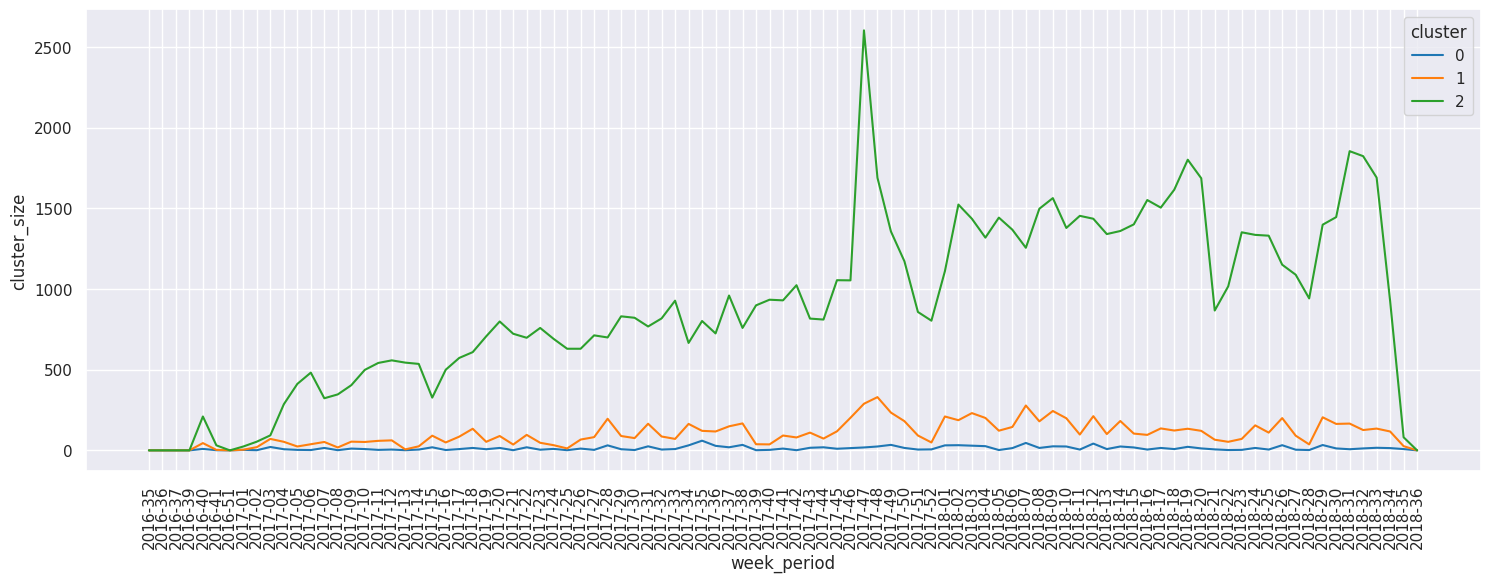

In [13]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.lineplot(df_result, x='week_period', y='cluster_size', hue='cluster', palette='tab10')
ax.tick_params(axis='x', labelrotation=90)

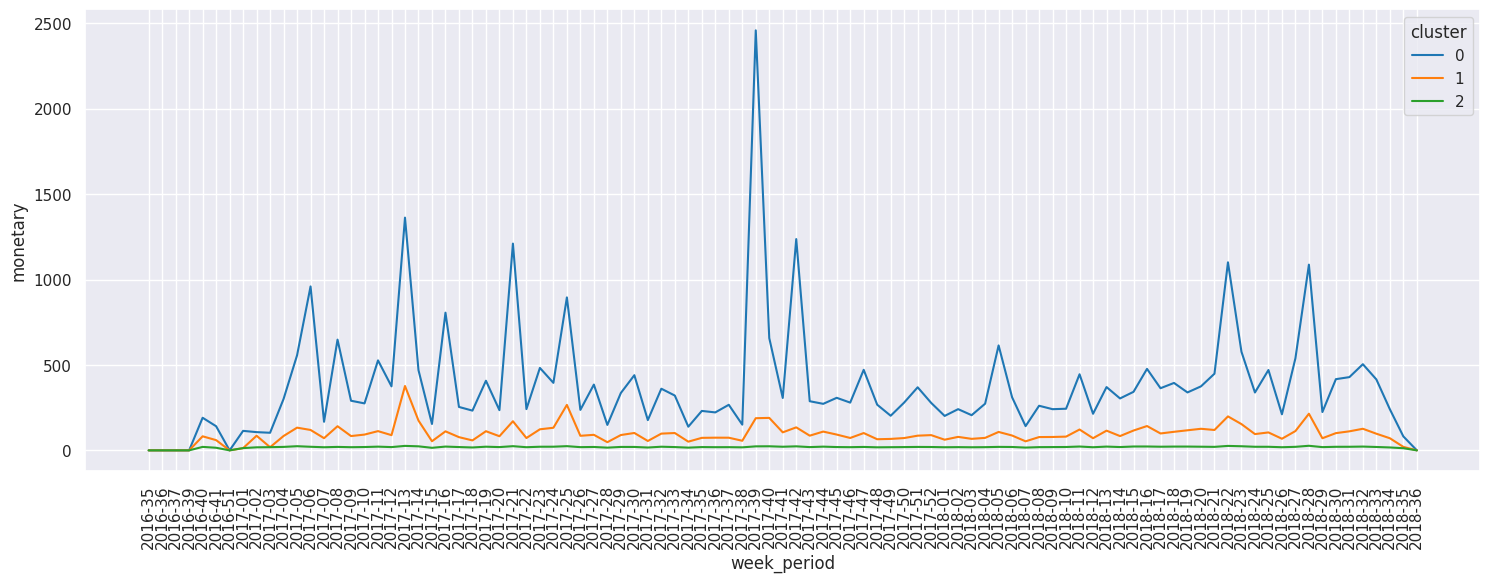

In [14]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.lineplot(df_result, x='week_period', y='monetary', hue='cluster', palette='tab10')
ax.tick_params(axis='x', labelrotation=90)

### Moyenne et Somme

In [15]:
df_result_mean = pd.DataFrame(result_mean)

Regardons l'évolution du nombre de clients par semaine.

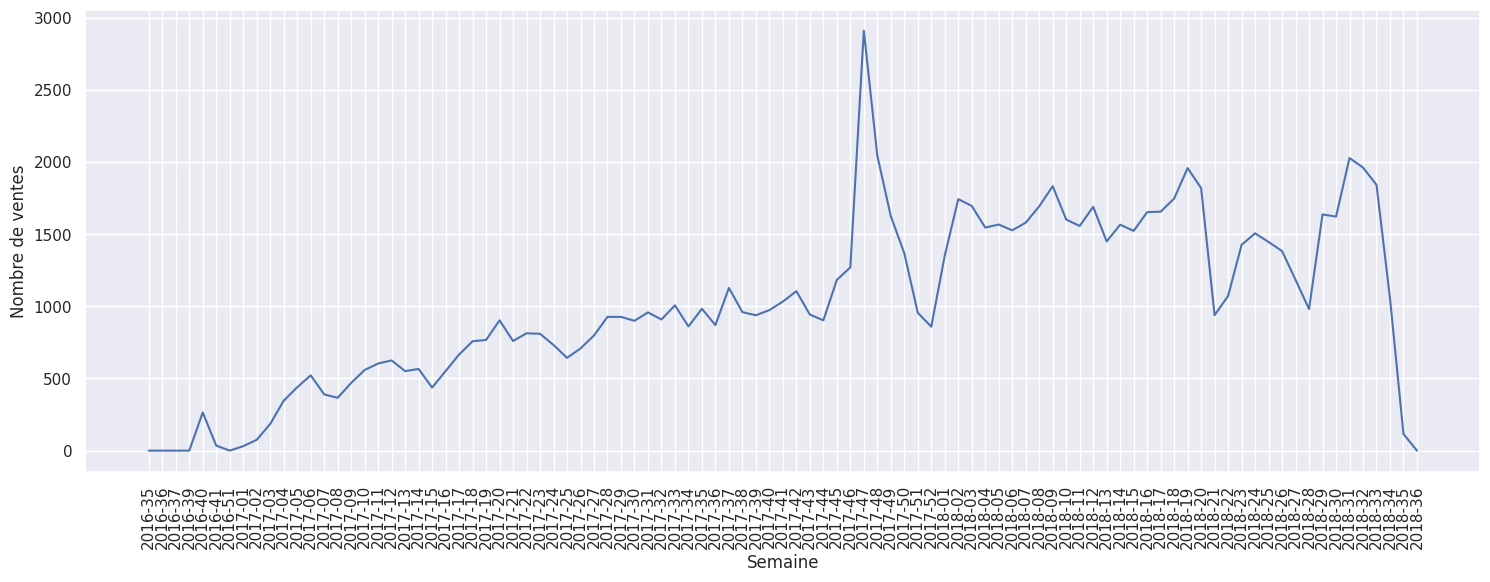

In [16]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.lineplot(df_result_mean, x='week_period', y='cluster_size')
plt.xlabel("Semaine")
plt.ylabel("Nombre de ventes")
ax.tick_params(axis='x', labelrotation=90)

Les données des 2 dernières semaines ne sont pas pertinentes car moins nombreuses. Nous ne les prendrons pas en compte dans le reste de notre étude. Regardons alors ce que donne la variable monetary sur cette période par semaine.

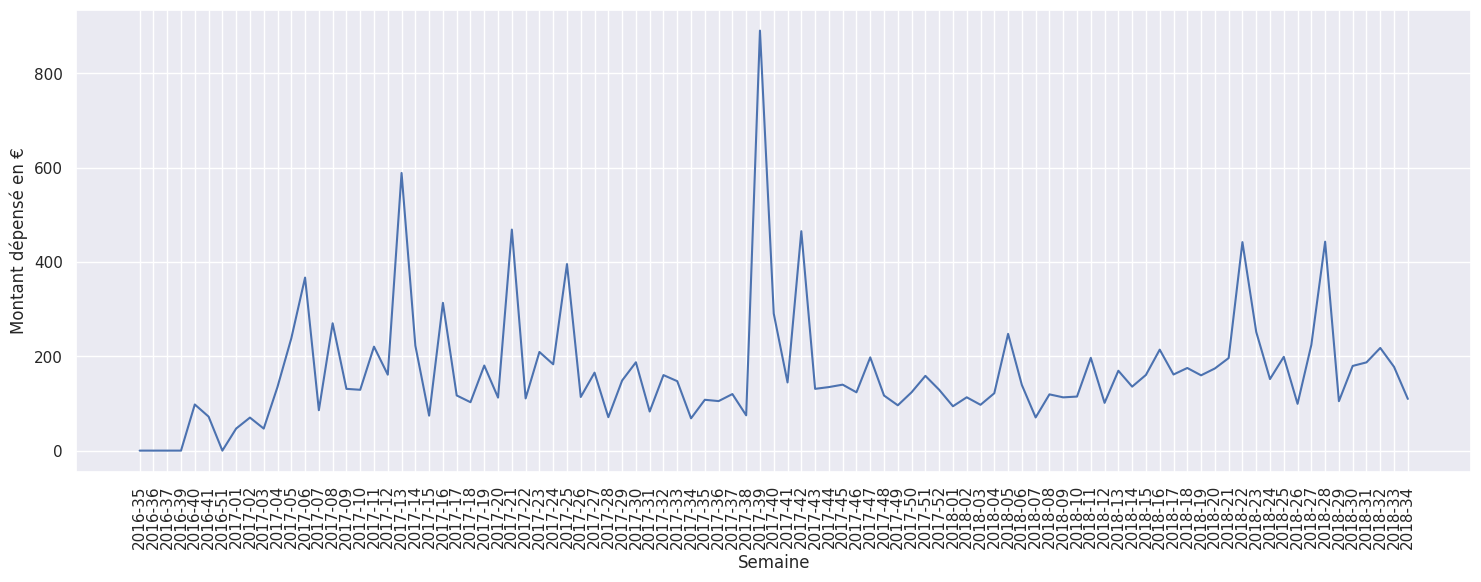

In [17]:
sub_data = df_result_mean.loc[df_result_mean["week_period"] <= '2018-34', :]
fig, ax = plt.subplots(figsize=(18, 6))
sns.lineplot(sub_data, x='week_period', y='monetary')
plt.xlabel("Semaine")
plt.ylabel("Montant dépensé en €")
ax.tick_params(axis='x', labelrotation=90)

D’une semaine à l’autre, il y a de grandes différences car il est difficile de simuler le comportement des clients.
L’idée est de déceler une stabilité globale sur une certaine période.
On sait que ce genre de segmentation doit être mis à jour dans des périodes allant de 3 à 8 semaines.
J’ai donc regardé pour chaque période, le comportement de la courbe.

In [18]:
sub_data_period = periodic_data.loc[periodic_data["week_period"] <= '2018-34', :]

In [19]:
def check_simulation_by_nb_week(df, nb_week=1):
    result, result_mean = compute_clustering_by_period(df, nb_week=nb_week, silent=True)
    df_result_mean = pd.DataFrame(result_mean)
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.lineplot(df_result_mean, x='week_period', y='monetary')
    plt.xlabel("Semaine")
    plt.ylabel("Montant dépensé en €")
    ax.tick_params(axis='x', labelrotation=90)
    plt.show()

Test avec interval de 3 semaines.


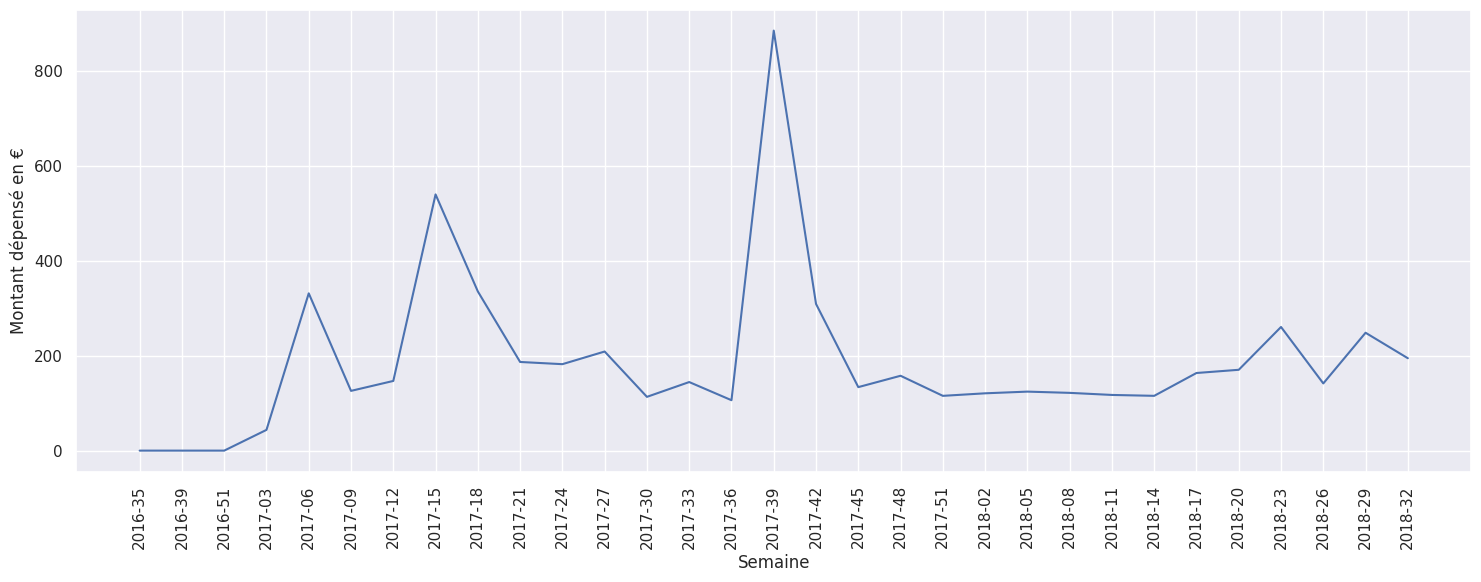

Test avec interval de 4 semaines.


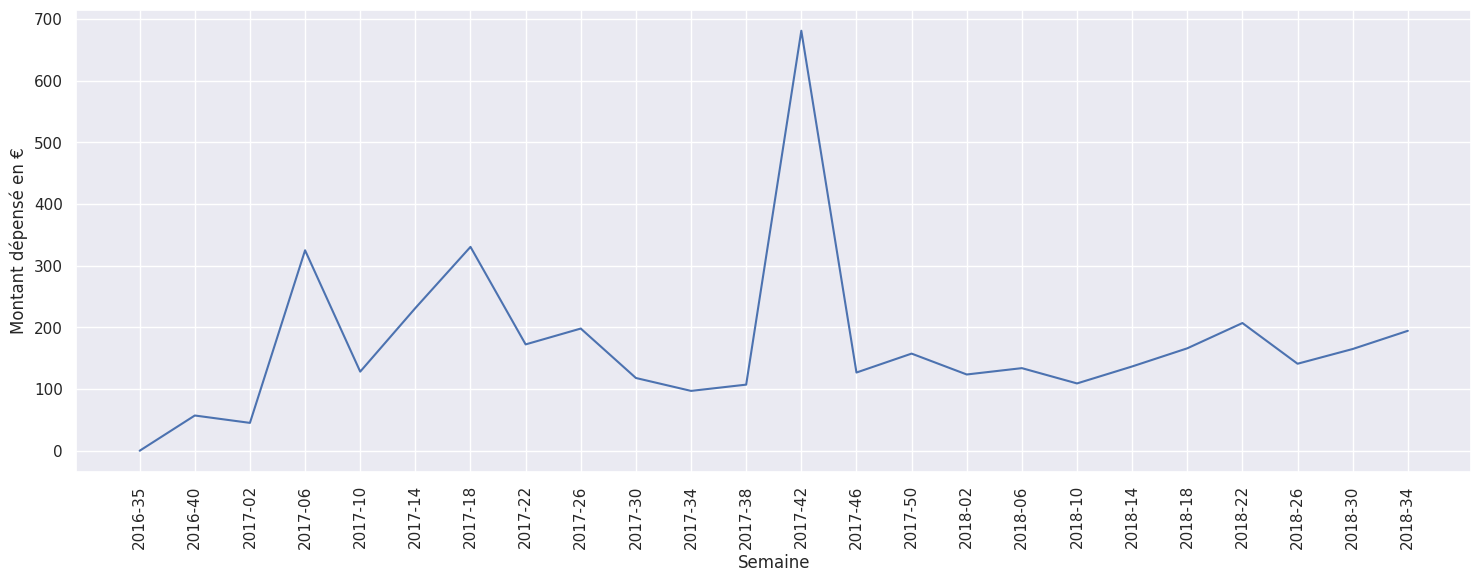

Test avec interval de 5 semaines.


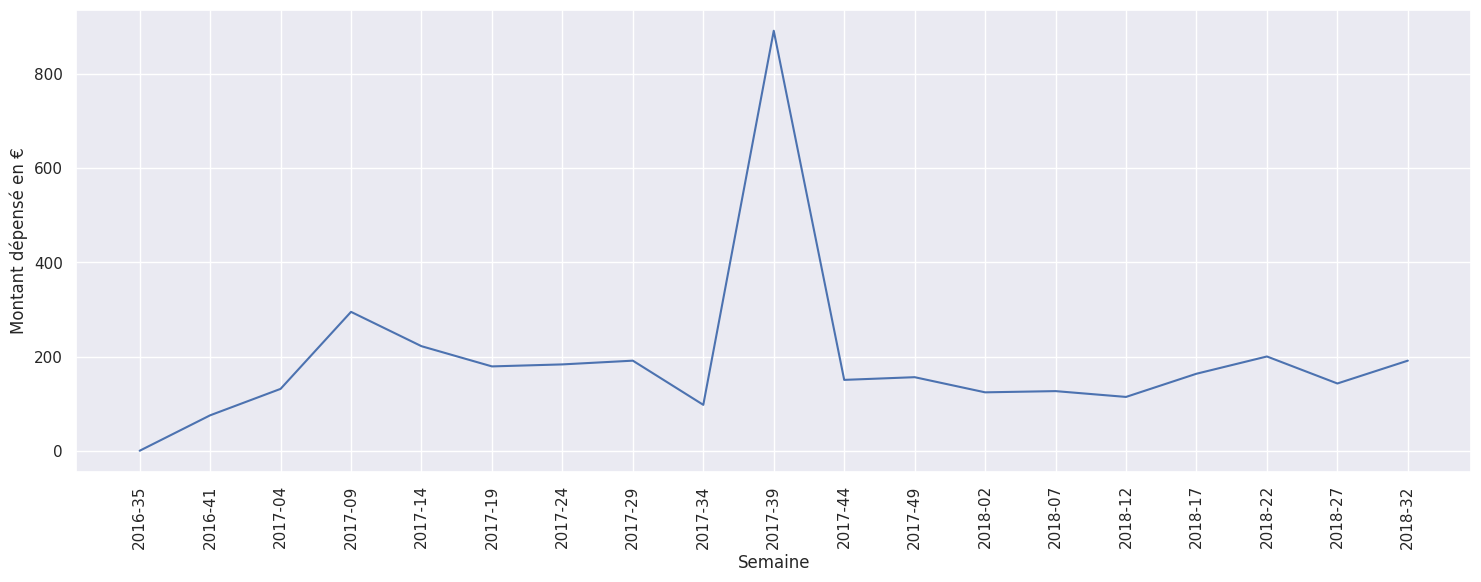

Test avec interval de 6 semaines.


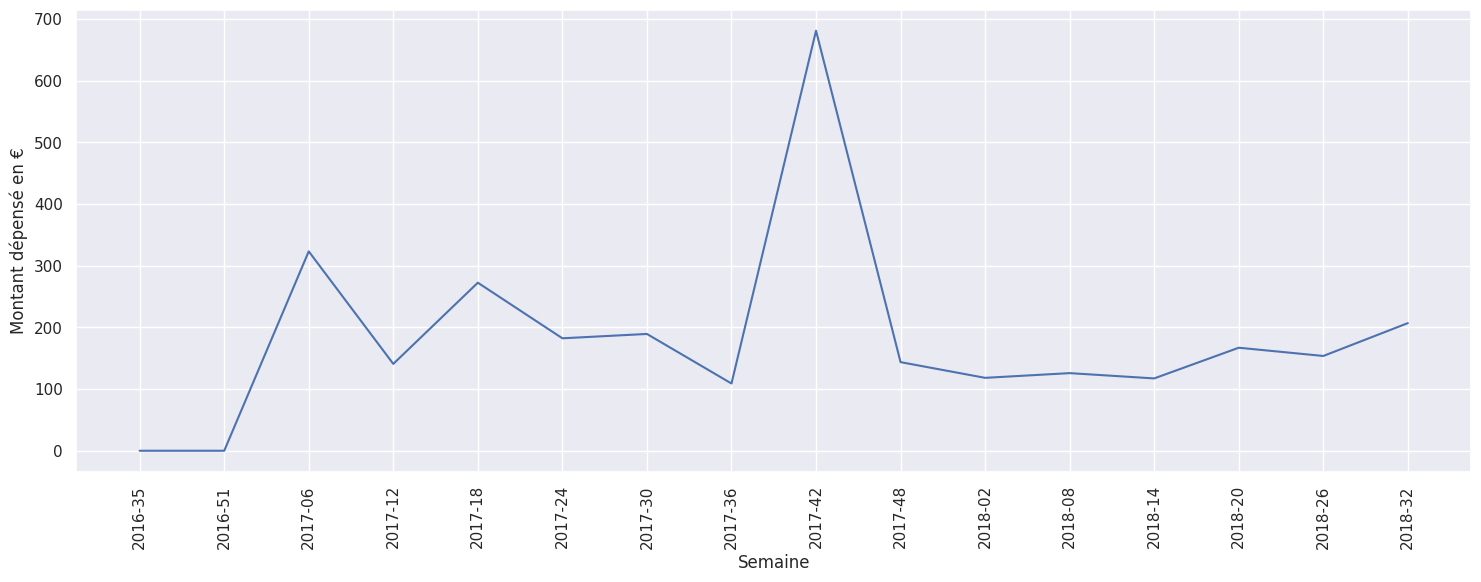

Test avec interval de 7 semaines.


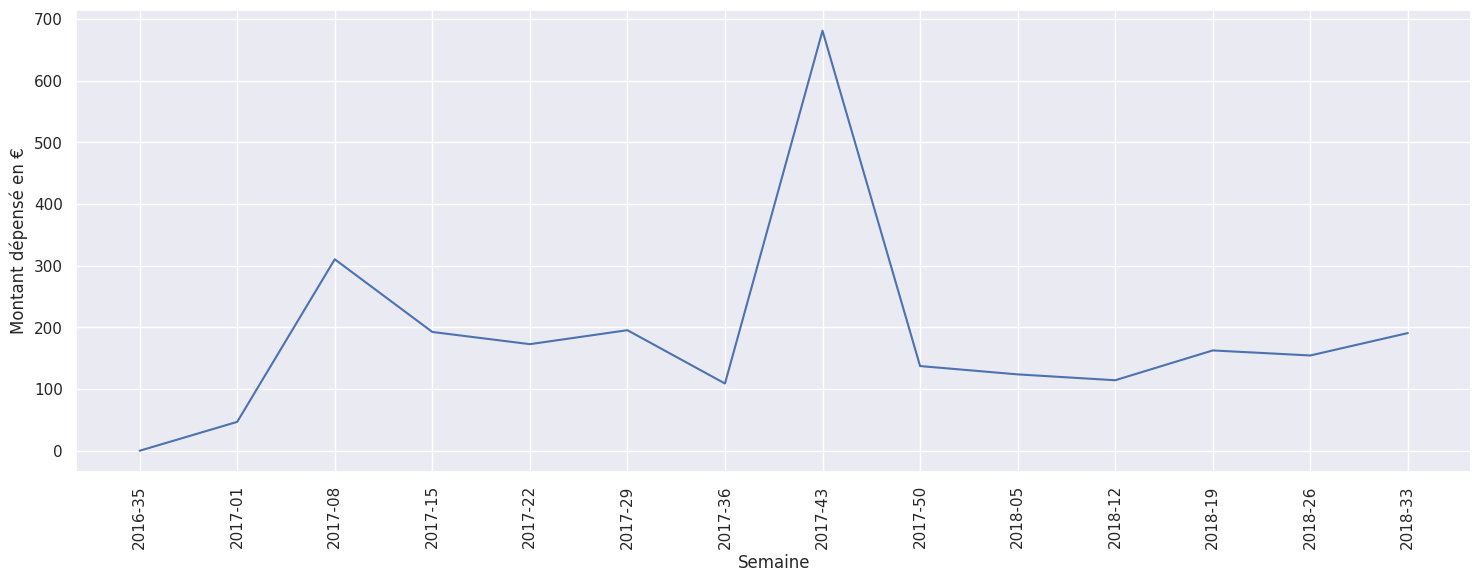

Test avec interval de 8 semaines.


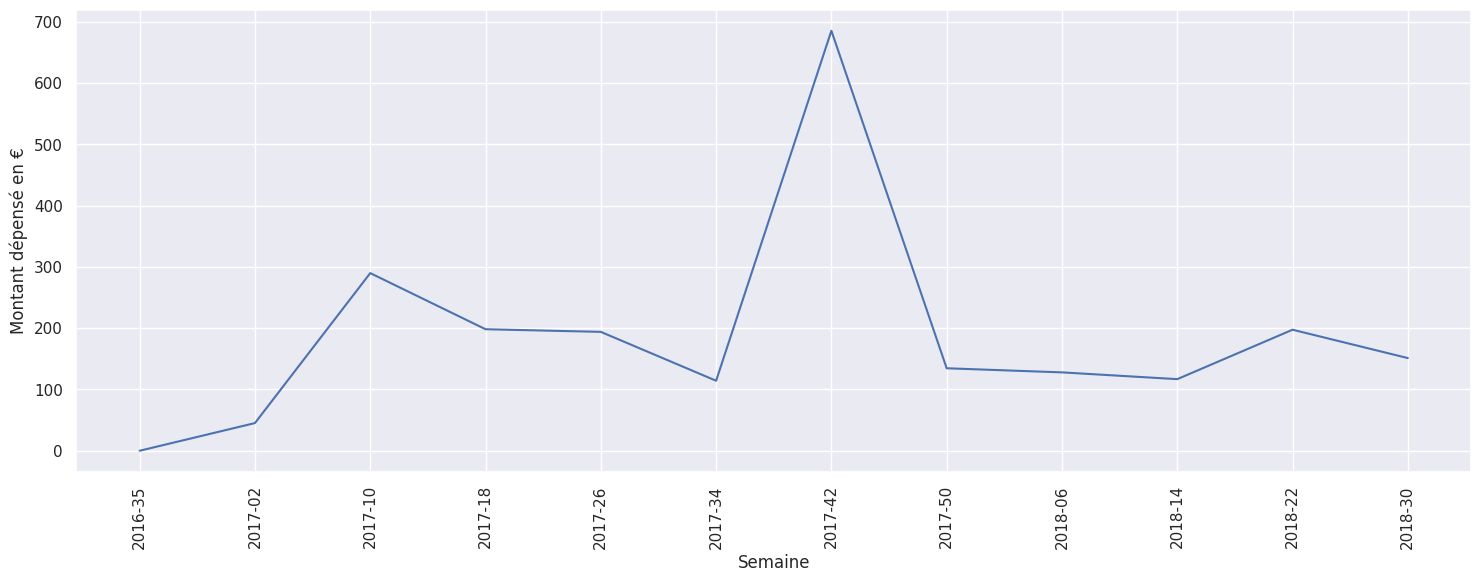

In [20]:
for nb_w in range(3, 9):
    print("Test avec interval de", nb_w, "semaines.")
    check_simulation_by_nb_week(sub_data_period, nb_w)

## Conclusions de la simulation

On peut voir notamment sur la courbe des 5 semaines que dans les dernières périodes, la courbe est plus stable.
Cela montre que si l’on souhaite faire des actions, c’est durant ces périodes de stabilité.
On peut le vérifier en revenant sur la courbe par semaine.

Si on part du creux au niveau de la semaine 29 de 2018.
On revient dans le passé à 4 périodes de 5 semaines : soit la semaine 9 de 2018.
En avançant de 5 en 5, on observe des valeurs assez proches, mais surtout ni pics, ni creux.
Cela semble donc une bonne approche pour partir sur une mise à jour de la segmentation sur 5 semaines.

On en conclut donc que la période idéale pour la mise à jour du clustering est de 5 semaines.